In [48]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
'''
@Env     		:   grizli
@File    		:   ~/emulator/emulator_v0.7/eldemo.ipynb
@Time    		:   2023/08/01 16:26:36
@Author  		:   Run Wen
@Version 		:   0.7
@Contact 		:   wenrun@pmo.ac.cn
@Description	:   plot demo diagram of emulator including detected emission line information
'''
import numpy as np
from astropy.table import Table
import sys
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import glob
from matplotlib.ticker import FuncFormatter,NullFormatter
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

import json
with open('emulator_parameters.json', 'r') as f:
    emulator_parameters = json.load(f)
gv_init_idx = emulator_parameters['gv_init_idx']
gv_end_idx = emulator_parameters['gv_end_idx']
gi_init_idx = emulator_parameters['gi_init_idx']
gi_end_idx = emulator_parameters['gi_end_idx']
gv_elwidth = round(emulator_parameters['gv_elwidth']/2)
gi_elwidth = round(emulator_parameters['gi_elwidth']/2)
el_detect_success_th = emulator_parameters['el_detect_success_th']

el_snr_th = 5 # the threshold of emission line snr which determines to show the emission line 

sys.path.append('/Users/rain/emulator/emulator_v0.7/utils.py')
from utils import *

matplotlib.rcParams['figure.figsize'] = [8, 4]

In [3]:
cat = h5py.File('/Users/rain/emulator/seedcat_0702/seedcat2_0420_1054_DECaLS_0csp_sfh200_bc2003_hr_stelib_chab_neb_300r_i0100_2dal8_10.hdf5','r')
file = h5py.File('/Users/rain/emulator/emulator_v0.68/CSST_grism_76660_seedcat2_0420_1054_DECaLS_0csp_sfh200_bc2003_hr_stelib_chab_neb_300r_i0100_2dal8_10.hdf5','r')

In [4]:
# get the index number of the total spectra
np.nonzero(file['ID'])[0]

array([    0,     1,     2, ..., 76657, 76658, 76659])

In [5]:
# show the spectra index with intrinsic and detected emission line in the original file
print(file['GV']['intri_el_id'][:])
print(file['GI']['intri_el_id'][:])

print(file['GV']['detect_el_id'][:])
print(file['GI']['detect_el_id'][:])

[    1     2     4 ... 76653 76655 76658]
[    3     4     8 ... 76648 76653 76655]
[    1     2     4 ... 76649 76653 76655]
[    3     4     8 ... 76648 76653 76655]


In [6]:
# get the index number of the el_intrinsic and el_detected spectra in GV and GI band
# very important to run the plot
gv_detect_index = [list(np.nonzero(file['ID'])[0]).index(x) for x in list(file['GV']['detect_el_id'][:])]
gv_intri_index = [list(np.nonzero(file['ID'])[0]).index(x) for x in list(file['GV']['intri_el_id'][:])]
gi_detect_index = [list(np.nonzero(file['ID'])[0]).index(x) for x in list(file['GI']['detect_el_id'][:])]
gi_intri_index = [list(np.nonzero(file['ID'])[0]).index(x) for x in list(file['GI']['intri_el_id'][:])]

In [7]:
print(gv_intri_index);print(len(gv_intri_index))
print(gv_detect_index);print(len(gv_detect_index))
print(gi_intri_index);print(len(gi_intri_index))
print(gi_detect_index);print(len(gi_detect_index))

[1, 2, 4, 5, 7, 11, 12, 14, 15, 17, 18, 23, 24, 25, 26, 28, 30, 37, 38, 41, 42, 43, 45, 50, 51, 53, 54, 57, 61, 63, 71, 72, 74, 75, 76, 78, 82, 83, 85, 88, 89, 92, 94, 95, 97, 100, 101, 102, 105, 108, 117, 118, 119, 121, 122, 124, 129, 132, 137, 140, 142, 144, 145, 148, 149, 151, 152, 153, 156, 157, 159, 160, 162, 167, 173, 174, 175, 176, 179, 184, 186, 188, 192, 195, 199, 200, 204, 206, 210, 213, 215, 217, 218, 224, 226, 228, 234, 238, 240, 247, 249, 250, 251, 252, 255, 257, 258, 260, 263, 268, 270, 271, 272, 274, 275, 277, 278, 282, 286, 287, 288, 291, 293, 294, 295, 298, 299, 300, 303, 304, 309, 311, 314, 315, 319, 322, 324, 327, 328, 332, 333, 344, 346, 347, 355, 356, 362, 363, 364, 372, 373, 375, 376, 377, 379, 382, 383, 386, 393, 395, 396, 397, 401, 404, 408, 409, 410, 414, 416, 417, 418, 420, 421, 422, 424, 426, 427, 428, 429, 430, 431, 433, 438, 440, 443, 444, 449, 451, 456, 459, 461, 464, 466, 469, 471, 473, 474, 476, 479, 483, 486, 487, 488, 490, 491, 492, 493, 495, 496, 501,

In [13]:
# get the el_intrinsic and el_detected mask of the total spectra in GV and GI band, mask length = 76660
gv_detect_index_mask = np.in1d(np.nonzero(file['ID'])[0], gv_detect_index)
gv_intri_index_mask = np.in1d(np.nonzero(file['ID'])[0], gv_intri_index)
gi_detect_index_mask = np.in1d(np.nonzero(file['ID'])[0], gi_detect_index)
gi_intri_index_mask = np.in1d(np.nonzero(file['ID'])[0], gi_intri_index)
print(len(gi_detect_index_mask))

76660


In [9]:
# select spectra with mean snr > 5
gv_snr_lg5_mask = file['parameters'][:,15][gv_detect_index_mask] > 5
print(len(gv_snr_lg5_mask))
gi_snr_lg5_mask = file['parameters'][:,16][gi_detect_index_mask] > 5
print(len(gi_snr_lg5_mask))

27128
21331


In [10]:
# select spectra with detected emission lines with mean snr > 5
gv_snr_lg5_index = np.nonzero(file['ID'])[0][gv_detect_index_mask][gv_snr_lg5_mask]
print(len(gv_snr_lg5_index))
gi_snr_lg5_index = np.nonzero(file['ID'])[0][gi_detect_index_mask][gi_snr_lg5_mask]
print(len(gi_snr_lg5_index))

813
2348


In [387]:
def eldemo(input_index,ymax,save):
    # for those with a wrong redshift source, and REMEMBER THIS SELECTION MAYBE NOT ENOUGH FOR THE WHOLE FILE! NEED TO BE UPDATED
    if cat['ID'][0] == b'0':
        catindex = input_index + 1 #
    else:
        catindex = input_index
    # index for the all spectra (in total 76660 of CSST_grism_76660_seedcat2_0420_1054_DECaLS_0csp_sfh200_bc2003_hr_stelib_chab_neb_300r_i0100_2dal8_10.hdf5)
    index = input_index
    gvidx1 = None
    gvidx2 = None
    giidx1 = None
    giidx2 = None
    # setting the figsize
    matplotlib.rcParams['figure.figsize'] = [20, 12]
    fig,ax = plt.subplots(1,1)
    # getting the corresponding magnitudes of three CSST slitless bands
    gu_mag = fnu2mAB(np.mean(file['GU']['flux_ujy'][index]*1e-29))
    gv_mag = fnu2mAB(np.mean(file['GV']['flux_ujy'][index]*1e-29))
    gi_mag = fnu2mAB(np.mean(file['GI']['flux_ujy'][index]*1e-29))
    # plot the noisy spectra
    ax.plot(file['GU']['wave'][:],file['GU']['flux_ujy_with_noise'][index],c='dodgerblue',lw=3,alpha=0.68,label='Simulated observed GU spectrum')
    ax.plot(file['GV']['wave'][:],file['GV']['flux_ujy_with_noise'][index],c='limegreen',lw=3,alpha=0.68,label='Simulated observed GV spectrum')
    ax.plot(file['GI']['wave'][:],file['GI']['flux_ujy_with_noise'][index],c='orangered',lw=3,alpha=0.68,label='Simulated observed GI spectrum')
        # ax.plot(wave_obs[catindex],fnu[catindex],c='k',lw=2,zorder=4,label='Input intrinsic spectrum')
    # plot the intrinsic spectra
    ax.plot(file['GU']['wave'][:],file['GU']['flux_ujy'][index],c='b',lw=3,ls='-',label='Simulated intrinsic GU spectrum')
    ax.plot(file['GV']['wave'][:],file['GV']['flux_ujy'][index],c='g',lw=3,ls='-',label='Simulated intrinsic GV spectrum')
    ax.plot(file['GI']['wave'][:],file['GI']['flux_ujy'][index],c='r',lw=3,ls='-',label='Simulated intrinsic GI spectrum')
        # ax.errorbar(file['GU']['wave'][:], file['GU']['flux_ujy_with_noise'][index], yerr=file['GU']['ferr'][idx], marker='.', ecolor = 'dodgerblue',color='dodgerblue',ms=3,elinewidth=1,linestyle='None', alpha=0.8,label='GU observed flux',zorder=3)
        # ax.errorbar(file['GV']['wave'][:], file['GV']['flux_ujy_with_noise'][index], yerr=file['GV']['ferr'][idx], marker='.', ecolor = 'limegreen',color='limegreen',ms=3,elinewidth=1,linestyle='None', alpha=0.8,label='GV observed flux',zorder=4)
        # ax.errorbar(file['GI']['wave'][:], file['GI']['flux_ujy_with_noise'][index], yerr=file['GI']['ferr'][idx], marker='.', ecolor = 'orangered',color='red',ms=3,elinewidth=1,linestyle='None', alpha=0.8,label='GI observed flux',zorder=5)
    # setting the textbox style
    props = dict(boxstyle=("Round, pad=0.2"), facecolor='white', alpha=1)

    # plot the GV emission line
    # test whether the index is in the gv_intri_index, if so, run the loop to plot the gv emission line
    if index in gv_intri_index:
        gvidx1 = list(file['GV']['intri_el_id']).index(index) # get the index for intrinsic spectra of gv, 29794
        # loop for emission lines detected in intrinsic spectra
        for i in range(len(file['GV']['intri_el_idx'][gvidx1])):
            # if emission lines number larger than 1, go this loop
            if len(file['GV']['intri_el_idx'][gvidx1]) > 1:
                # plot a wide vertical line to show the intrinsic emission line location and numbers
                ax.axvline(file['GV']['wave'][file['GV']['intri_el_idx'][gvidx1][i]+gv_init_idx],c='k',lw=30,alpha=0.3,zorder=1)
                ax.annotate('{0}'.format(i+1), xy=(file['GV']['wave'][file['GV']['intri_el_idx'][gvidx1][i]+gv_init_idx], ymax/20), c='g', bbox=props, fontsize=25)
                # test whether the index is in the gv_detect_index, if so run the loop to plot the detected emission lines in noisy spectra
                if index in gv_detect_index:
                    gvidx2 = list(file['GV']['detect_el_id']).index(index) # get the index for noisy spectra of gv, 26882
                    # test whether the detected emission line in noisy spectra is within the el_detect_success_th (e.g. 50Å), and store the difference value in diff array
                    diff = [abs(j - file['GV']['intri_el_wave'][gvidx1][i]) for j in file['GV']['detect_el_wave'][gvidx2][:] if abs(j - file['GV']['intri_el_wave'][gvidx1][i]) <= el_detect_success_th]
                    # test whether the diff array is none
                    if len(diff) == 0:
                        ax.text(0.35, (0.84 - 0.06*i), 'No EL_{0} detection'.format(i+1), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')
                    elif  len(diff) !=0: 
                        # find the min of diff to select the detected emssion line in noisy spectra corresponds to the detected intrinsic spectra
                        min_diff = min(diff)
                        # get the index of min diff in the detected noisy emission line array (file['GV']['detect_el_wave'][gvidx2][:])
                        # if idx not none, means a detected emission line in both noisy and intrinsic spectra
                        idx = np.argmin(abs(file['GV']['detect_el_wave'][gvidx2][:] - (file['GV']['intri_el_wave'][gvidx1][i] + min_diff)))
                        # test whether the min diff emission line has snr larger than el_snr_th, if so, plot and text this emission line
                        if file['GV']['detect_el_snr'][gvidx2][idx] >= el_snr_th:
                            ax.axvline(file['GV']['wave'][file['GV']['detect_el_idx'][gvidx2][idx]+gv_init_idx],c='k',ls='-',lw=3)
                            # print(file['GV']['detect_el_snr'][gvidx2][idx])
                            ax.text(0.35, (0.84 - 0.06*i), 'Detected EL_{0} snr: {1}'.format(i+1, format(file['GV']['detect_el_snr'][gvidx2][idx],'.2f')), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')
                        # if not, plot and text this emission line
                        elif file['GV']['detect_el_snr'][gvidx2][idx] < el_snr_th:
                            ax.axvline(file['GV']['wave'][file['GV']['detect_el_idx'][gvidx2][idx]+gv_init_idx],c='k',ls='--',lw=3)
                            ax.text(0.35, (0.84 - 0.06*i), 'Detected EL_{0} snr: {1}'.format(i+1, format(file['GV']['detect_el_snr'][gvidx2][idx],'.2f')), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')
                            # ax.text(0.37, (0.85), 'No SNR > {0} EL detected'.format(el_snr_th), transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props, color='g')
                # the index is not in the gv_detect_index, text no emission line detected in noisy spectra
                elif index not in gv_detect_index:
                    ax.text(0.35, (0.84), 'No noisy EL detection', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')

            # if emission lines number equals 1, go this loop, this is due to the array structure, loop form is the same as the >1 loop
            elif len(file['GV']['intri_el_idx'][gvidx1]) == 1:

                ax.axvline(file['GV']['wave'][file['GV']['intri_el_idx'][gvidx1]+gv_init_idx],c='k',lw=30,alpha=0.3,zorder=1)
                ax.annotate('{0}'.format(i+1), xy=(file['GV']['wave'][file['GV']['intri_el_idx'][gvidx1]+gv_init_idx], ymax/20), c='g', bbox=props, fontsize=25)

                if index in gv_detect_index:

                    gvidx2 = list(file['GV']['detect_el_id']).index(index) # index for noisy spectra of gv, 26882

                    diff = [abs(j - file['GV']['intri_el_wave'][gvidx1][i]) for j in file['GV']['detect_el_wave'][gvidx2][:] if abs(j - file['GV']['intri_el_wave'][gvidx1][i]) <= el_detect_success_th]

                    if len(diff) == 0:
                        ax.text(0.35, (0.84 - 0.06*i), 'No EL_{0} detection'.format(i+1), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')
                    elif  len(diff) !=0: 
                        min_diff = min(diff)
                        idx = np.argmin(abs(file['GV']['detect_el_wave'][gvidx2][:] - (file['GV']['intri_el_wave'][gvidx1][i] + min_diff)))

                        if file['GV']['detect_el_snr'][gvidx2][idx] >= el_snr_th:
                            ax.axvline(file['GV']['wave'][file['GV']['detect_el_idx'][gvidx2][idx]+gv_init_idx],c='k',ls='-',lw=3)
                            # print(file['GV']['detect_el_snr'][gvidx2][k])
                            ax.text(0.35, (0.84 - 0.06*i), 'Detected EL_{0} snr: {1}'.format(i+1, format(file['GV']['detect_el_snr'][gvidx2][idx],'.2f')), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')
                        elif file['GV']['detect_el_snr'][gvidx2][idx] < el_snr_th:
                            ax.axvline(file['GV']['wave'][file['GV']['detect_el_idx'][gvidx2][idx]+gv_init_idx],c='k',ls='--',lw=3)
                            ax.text(0.35, (0.84 - 0.06*i), 'Detected EL_{0} snr: {1}'.format(i+1, format(file['GV']['detect_el_snr'][gvidx2][idx],'.2f')), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')

                elif index not in gv_detect_index:
                    ax.text(0.35, (0.84), 'No noisy EL detection', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')
    # the index is not in the gv_intri_index, text it
    elif index not in gv_intri_index:
        ax.text(0.35, (0.84), 'No intrinsic EL detection', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='g')

    # plot the GV emission line
    if index in gi_intri_index:
        giidx1 = list(file['GI']['intri_el_id']).index(index) # index for intrinsic spectra of gi, 23048
    
        for i in range(len(file['GI']['intri_el_idx'][giidx1])):
            if len(file['GI']['intri_el_idx'][giidx1]) > 1:

                ax.axvline(file['GI']['wave'][file['GI']['intri_el_idx'][giidx1][i]+gi_init_idx],c='k',lw=30,alpha=0.3,zorder=1)
                ax.annotate('{0}'.format(i+1), xy=(file['GI']['wave'][file['GI']['intri_el_idx'][giidx1][i]+gi_init_idx], ymax/20), c='r', bbox=props, fontsize=25)

                if index in gi_detect_index:

                    giidx2 = list(file['GI']['detect_el_id']).index(index) # index for noisy spectra of gi, 21139

                    diff = [abs(j - file['GI']['intri_el_wave'][giidx1][i]) for j in file['GI']['detect_el_wave'][giidx2][:] if abs(j - file['GI']['intri_el_wave'][giidx1][i]) <= el_detect_success_th]
                    # print(i)
                    if len(diff) == 0:
                        ax.text(0.68, (0.84 - 0.06*i), 'No EL_{0} detected'.format(i+1), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')
                    elif  len(diff) !=0: 
                        min_diff = min(diff)
                        idx = np.argmin(abs(file['GI']['detect_el_wave'][giidx2][:] - (file['GI']['intri_el_wave'][giidx1][i] + min_diff)))
                        
                        if file['GI']['detect_el_snr'][giidx2][idx] >= el_snr_th:
                            ax.axvline(file['GI']['wave'][file['GI']['detect_el_idx'][giidx2][idx]+gi_init_idx],c='k',ls='-',lw=3)
                            # print(file['GI']['detect_el_snr'][giidx2][k])
                            ax.text(0.68, (0.84 - 0.06*i), 'Detected EL_{0} snr: {1}'.format(i+1, format(file['GI']['detect_el_snr'][giidx2][idx],'.2f')), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')
                        elif file['GI']['detect_el_snr'][giidx2][idx] < el_snr_th:
                            ax.axvline(file['GI']['wave'][file['GI']['detect_el_idx'][giidx2][idx]+gi_init_idx],c='k',ls='--',lw=3)
                            ax.text(0.68, (0.84 - 0.06*i), 'Detected EL_{0} snr: {1}'.format(i+1, format(file['GI']['detect_el_snr'][giidx2][idx],'.2f')), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')
                
                elif index not in gi_detect_index:
                    ax.text(0.68, (0.84), 'No noisy EL detection', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')


            elif len(file['GI']['intri_el_idx'][giidx1]) == 1:
                ax.axvline(file['GI']['wave'][file['GI']['intri_el_idx'][giidx1]+gi_init_idx],c='k',lw=30,alpha=0.3,zorder=1)
                ax.annotate('{0}'.format(i+1), xy=(file['GI']['wave'][file['GI']['intri_el_idx'][giidx1]+gi_init_idx], ymax/20), c='r', bbox=props, fontsize=25)

                if index in gi_detect_index:
                    
                    giidx2 = list(file['GI']['detect_el_id']).index(index) # index for noisy spectra of gi, 21139

                    diff = [abs(j - file['GI']['intri_el_wave'][giidx1][i]) for j in file['GI']['detect_el_wave'][giidx2][:] if abs(j - file['GI']['intri_el_wave'][giidx1][i]) <= el_detect_success_th]
                    if len(diff) == 0:
                        ax.text(0.68, (0.84 - 0.06*i), 'No EL_{0} detection'.format(i+1), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')
                    elif  len(diff) !=0: 
                        min_diff = min(diff)
                        # find the index of min between detected el and intrinsic el
                        idx = np.argmin(abs(file['GI']['detect_el_wave'][giidx2][:] - (file['GI']['intri_el_wave'][giidx1][i] + min_diff)))
                        if file['GI']['detect_el_snr'][giidx2][idx] >= el_snr_th:
                            ax.axvline(file['GI']['wave'][file['GI']['detect_el_idx'][giidx2][idx]+gi_init_idx],c='k',ls='-',lw=3)
                            # print(file['GI']['detect_el_snr'][giidx2][k])
                            ax.text(0.68, (0.84 - 0.06*i), 'Detected EL_{0} snr: {1}'.format(i+1, format(file['GI']['detect_el_snr'][giidx2][idx],'.2f')), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')
                        elif file['GI']['detect_el_snr'][giidx2][idx] < el_snr_th:
                            ax.axvline(file['GI']['wave'][file['GI']['detect_el_idx'][giidx2][idx]+gi_init_idx],c='k',ls='--',lw=3)
                            ax.text(0.68, (0.84 - 0.06*i), 'Detected EL_{0} snr: {1}'.format(i+1, format(file['GI']['detect_el_snr'][giidx2][idx],'.2f')), transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')

                elif index not in gi_detect_index:
                    ax.text(0.68, (0.84), 'No noisy EL detection', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')

    elif index not in gi_intri_index:
        ax.text(0.68, (0.84), 'No intrinsic EL detection', transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props, color='r')

    # setting three grism band labels
    gu_label = [Line2D([0], [0], color='dodgerblue', ls='-', lw=2, label='GU band: {0} mag  \n'
                                                                        'mean SNR = {1}'.format(format(gu_mag,'.2f'), format(file['parameters'][index,14],'.2f')))]
    gv_label = [Line2D([0], [0], color='limegreen', ls='-', lw=2, label='GV band: {0} mag  \n'
                                                                        'mean SNR = {1}'.format(format(gv_mag,'.2f'), format(file['parameters'][index,15],'.2f')))]
    gi_label = [Line2D([0], [0], color='orangered', ls='-', lw=2, label='GI band: {0} mag  \n'
                                                                        'mean SNR = {1}'.format(format(gi_mag,'.2f'), format(file['parameters'][index,16],'.2f')))]
    el_label = [Line2D([0], [0], color='k', ls='-', lw=10, label='Intrinsic EL detection', alpha=0.3),
                Line2D([0], [0], color='k', ls='--', lw=2, label='Detected EL (SNR < {0}) '.format(el_snr_th)),
                Line2D([0], [0], color='k', ls='-', lw=2, label='Detected EL (SNR > {0}) '.format(el_snr_th))]
    # setting legends
    gu_legend = ax.legend(handles=gu_label, prop={'size':25}, framealpha=1, loc='upper left')
    gv_legend = ax.legend(handles=gv_label, prop={'size':25}, framealpha=1, loc='upper center')
    gi_legend = ax.legend(handles=gi_label, prop={'size':25}, framealpha=1, loc='upper right')
    el_legend = ax.legend(handles=el_label, prop={'size':20}, framealpha=1, loc='upper left', bbox_to_anchor=(0,0.85))
    # add labels to legends
    ax.add_artist(gu_legend)
    ax.add_artist(gv_legend)
    ax.add_artist(gi_legend)
    ax.add_artist(el_legend)
    # setting main parameters information
    ax.text(0.016, 0.5,'DESI ID: {0}\n'
                        '(R.A., Decl.) = ({1}, {2})\n' 
                        'z = {3}\n'
                        'n = {4}, Re = {5} pix\n'
                        'PA = {6} deg, b/a = {7}'.format(int(file['ID'][index].decode('utf-8')),format(file['parameters'][index,0],'.4f'), format(file['parameters'][index,1],'.4f'), format(file['parameters'][index,2],'.4f'),
                                                format(file['parameters'][index,6],'.2f'), format(file['parameters'][index,7],'.2f'), format(file['parameters'][index,8],'.2f'), format(file['parameters'][index,9],'.2f'))
                        , transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props)
    # setting the plot parameters
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.tick_params(labelsize=30)
    ax.tick_params(which='major',direction='in', length=10, width=3, top=True, right=True, zorder=100)
    ax.tick_params(which='minor',direction='in', top=True, right=True, zorder=100)
    ax.set_ylim(0,ymax)
    ax.set_xlim(2200,10800)
    ax.set_xticks([4000,6000,8000,10000])
    ax.set_yticks([0,ymax*0.2,ymax*0.4,ymax*0.6,ymax*0.8,ymax])
    ax.set_xlabel('Wavelength (Å)',fontsize=30,labelpad=10)
    ax.set_ylabel('Flux ($\mu Jy$)',fontsize=30,labelpad=10)

    print('catindex = ',catindex) # index of the cat (oringial input hdf5 file)
    print('index = ',index)
    print('gvidx1 = ',gvidx1)
    print('gvidx2 = ',gvidx2)
    print('giidx1 = ',giidx1)
    print('giidx2 = ' ,giidx2)

    plt.subplots_adjust(top=0.9,bottom=0.15,left=0.15,right=0.95,hspace=0,wspace=0)
    if save == True:
        plt.savefig('{0}_eldemo.pdf'.format(input_index))
    plt.show()

catindex =  5
index =  4
gvidx1 =  2
gvidx2 =  2
giidx1 =  1
giidx2 =  1


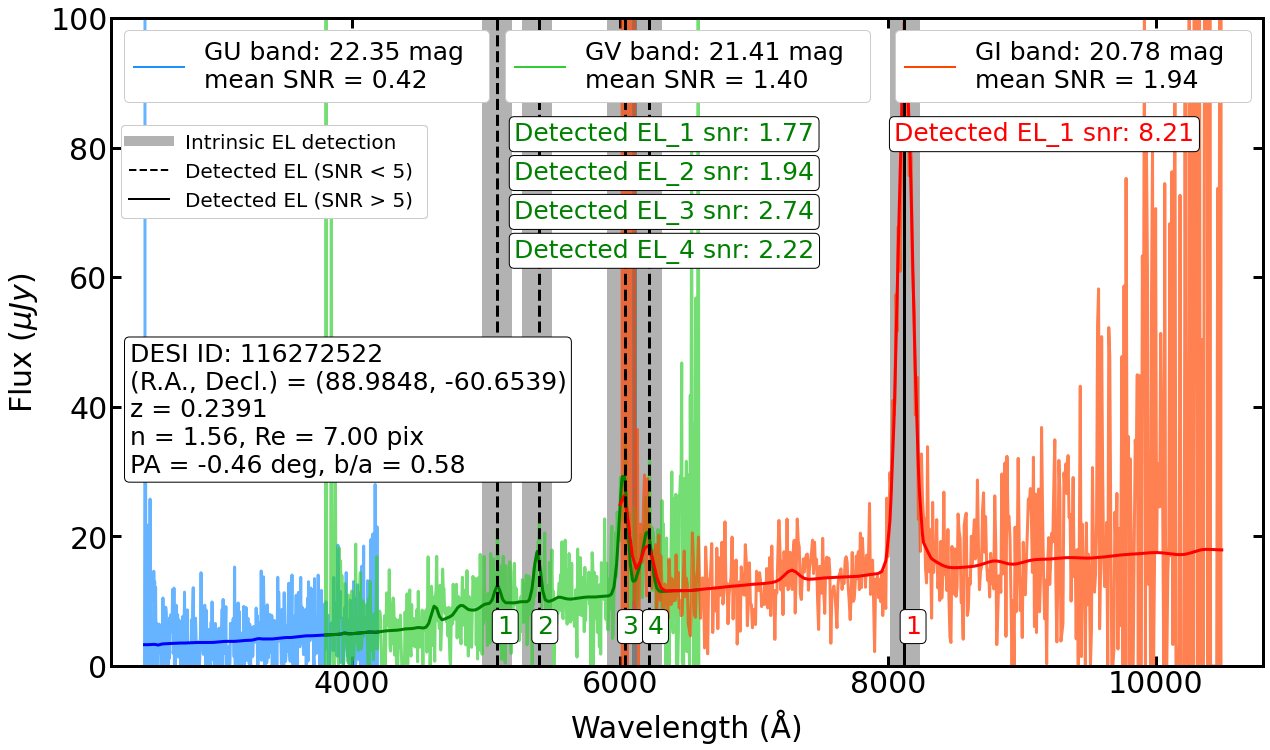

In [388]:
eldemo(4,100,None)

catindex =  76018
index =  76017
gvidx1 =  29803
gvidx2 =  None
giidx1 =  23052
giidx2 =  None


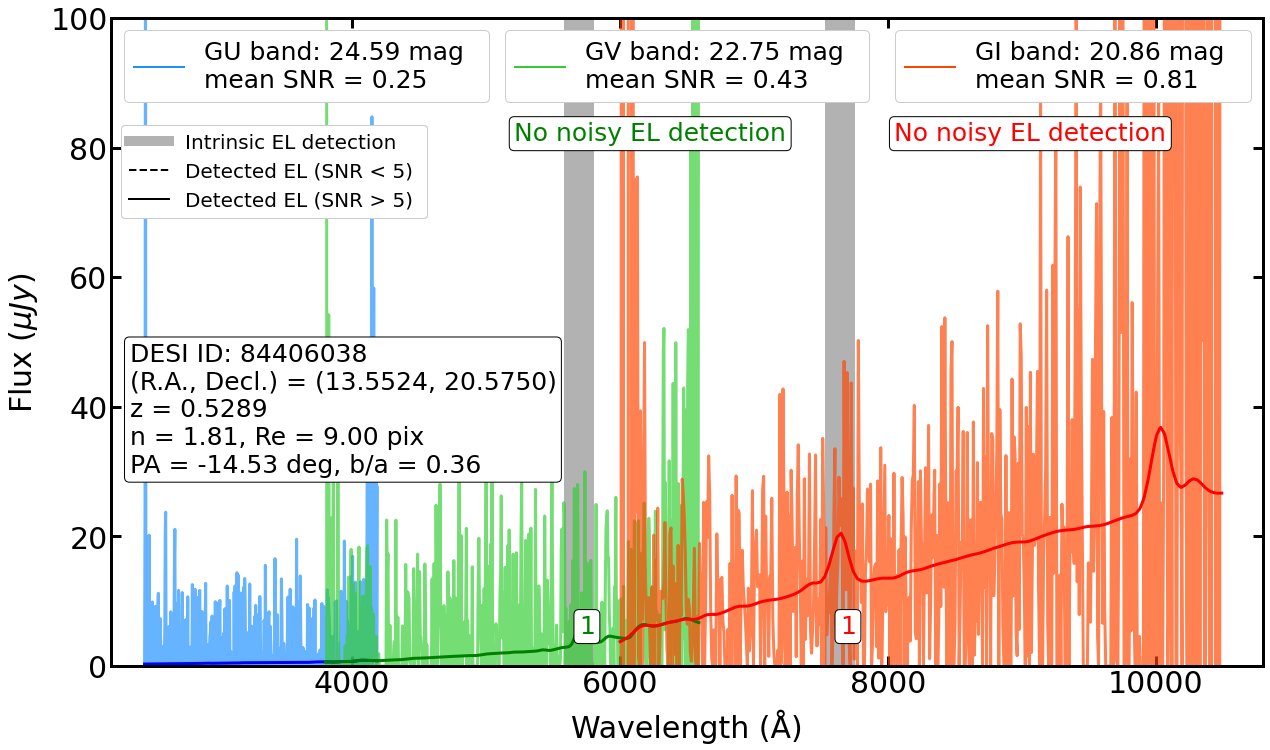

In [389]:
eldemo(76017,100,save=True)

catindex =  59594
index =  59593
gvidx1 =  23404
gvidx2 =  21133
giidx1 =  18160
giidx2 =  16628


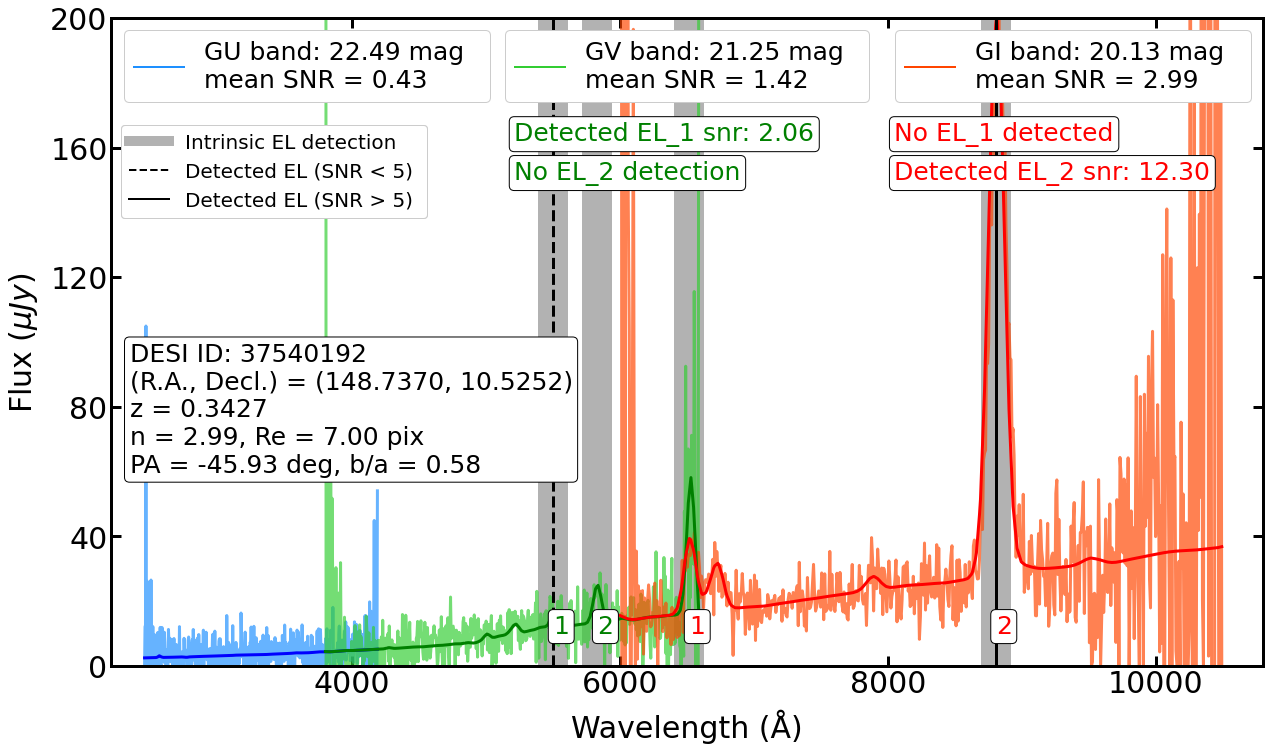

In [390]:
eldemo(59593,200,save=True)

catindex =  75996
index =  75995
gvidx1 =  29794
gvidx2 =  26882
giidx1 =  23048
giidx2 =  21139


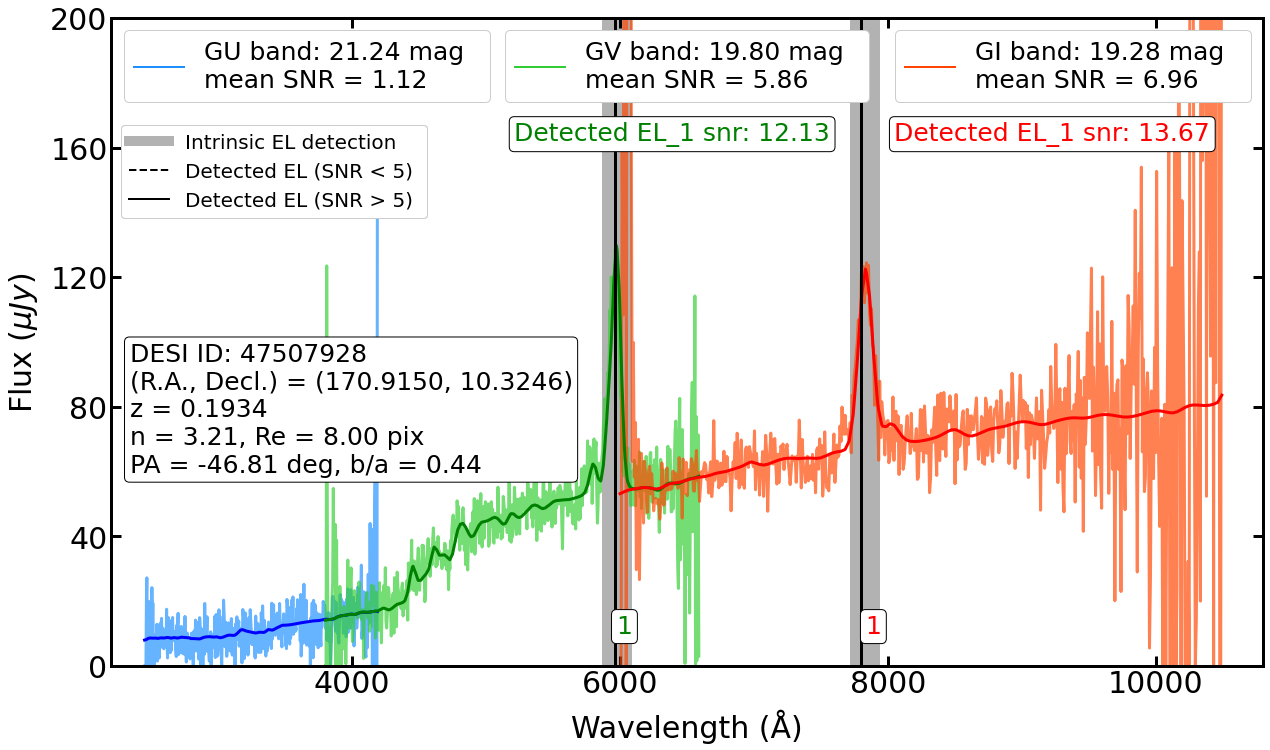

In [391]:
eldemo(gv_snr_lg5_index[-3],200,save=True)

catindex =  384
index =  383
gvidx1 =  156
gvidx2 =  136
giidx1 =  109
giidx2 =  99


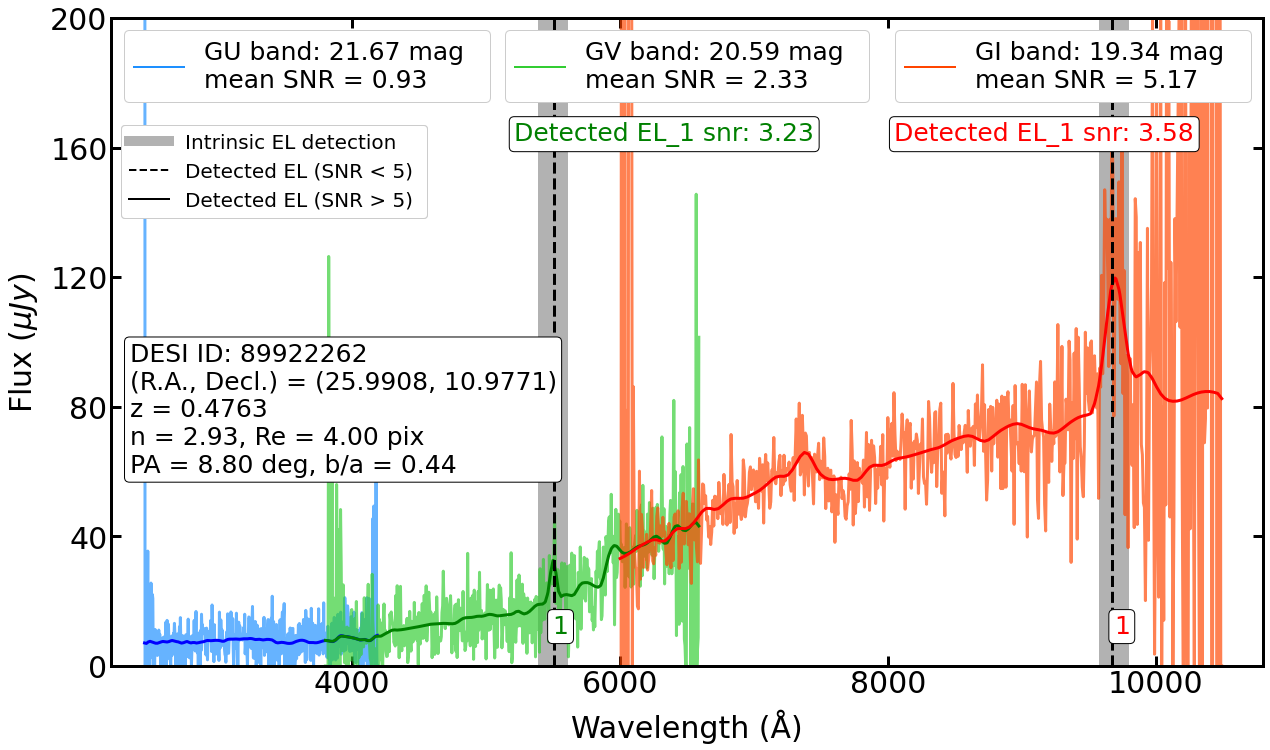

In [392]:
eldemo(gi_snr_lg5_index[4],200,save=True)

catindex =  55818
index =  55817
gvidx1 =  None
gvidx2 =  None
giidx1 =  None
giidx2 =  None


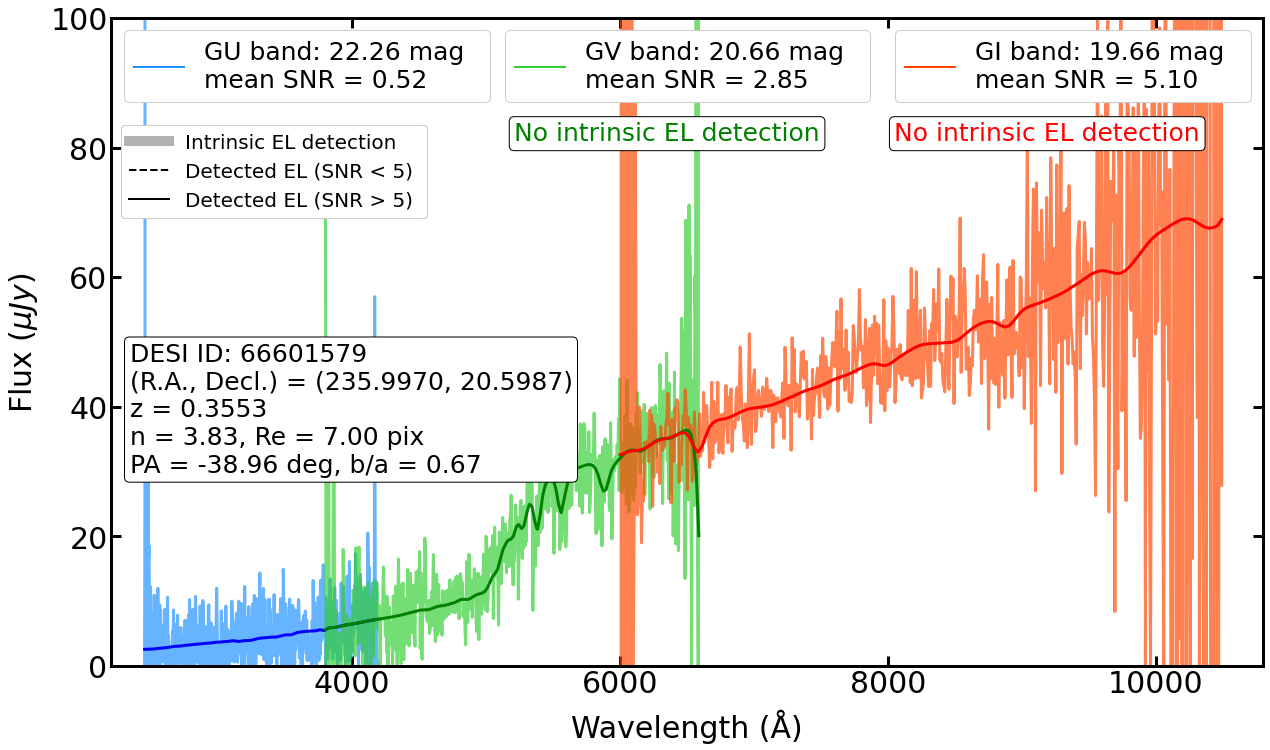

In [393]:
eldemo(55817,100,save=True)

catindex =  53755
index =  53754
gvidx1 =  21102
gvidx2 =  19050
giidx1 =  16396
giidx2 =  15018


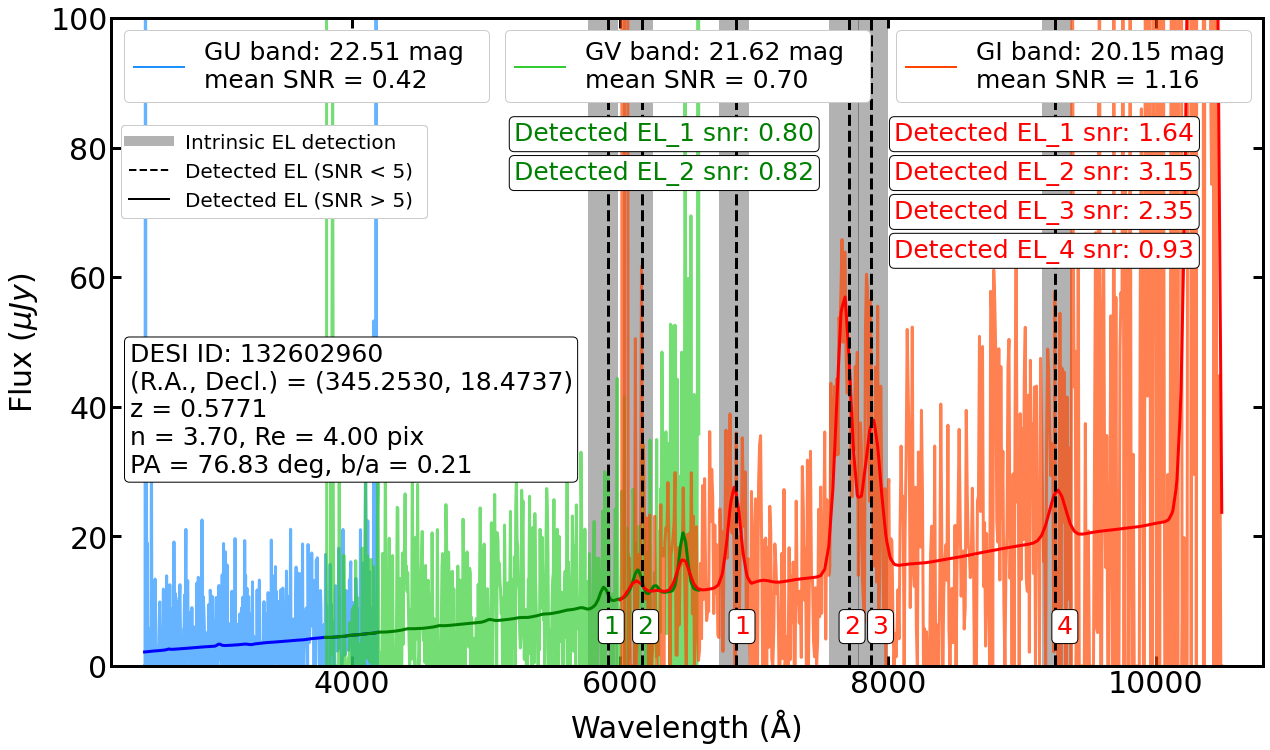

In [394]:
eldemo(53754,100,save=True)

catindex =  34581
index =  34580
gvidx1 =  None
gvidx2 =  None
giidx1 =  10594
giidx2 =  9703


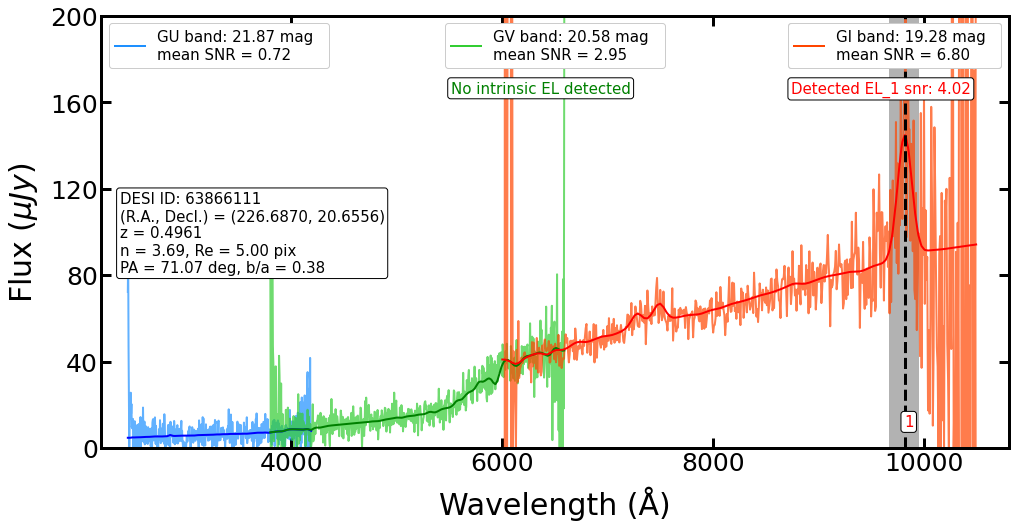

In [291]:
eldemo(34580,200,None)

catindex =  40965
index =  40964
gvidx1 =  16056
gvidx2 =  14480
giidx1 =  12497
giidx2 =  None


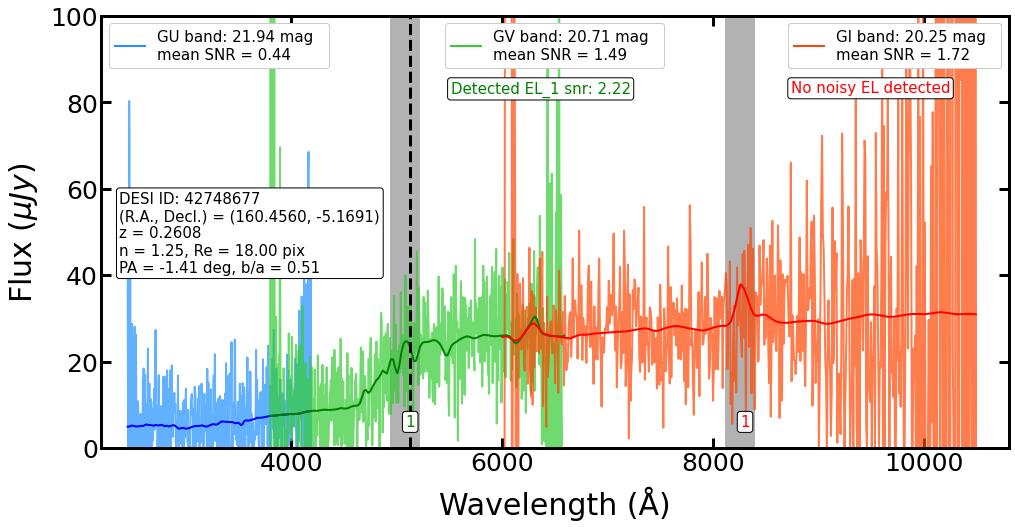

In [293]:
eldemo(40964,100,None)

catindex =  39934
index =  39933
gvidx1 =  None
gvidx2 =  None
giidx1 =  None
giidx2 =  None


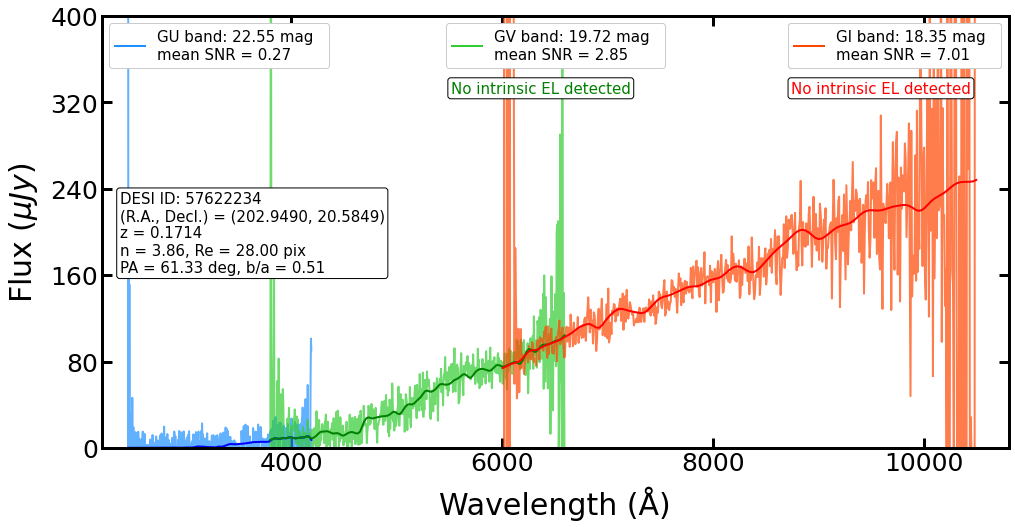

In [294]:
eldemo(39933,400,None)

catindex =  67473
index =  67472
gvidx1 =  26501
gvidx2 =  23918
giidx1 =  20560
giidx2 =  18850


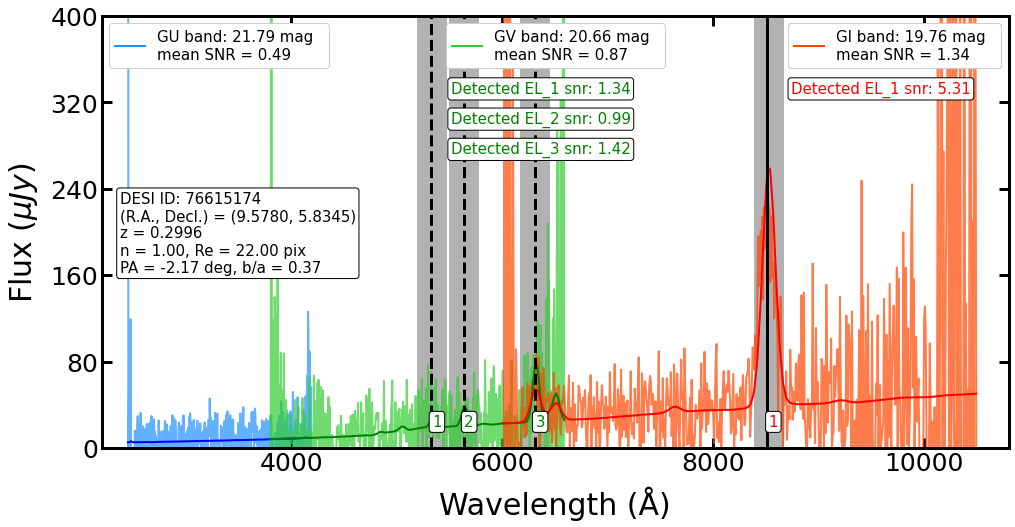

In [295]:
eldemo(67472,400,None)

catindex =  26678
index =  26677
gvidx1 =  10422
gvidx2 =  9399
giidx1 =  8159
giidx2 =  7479


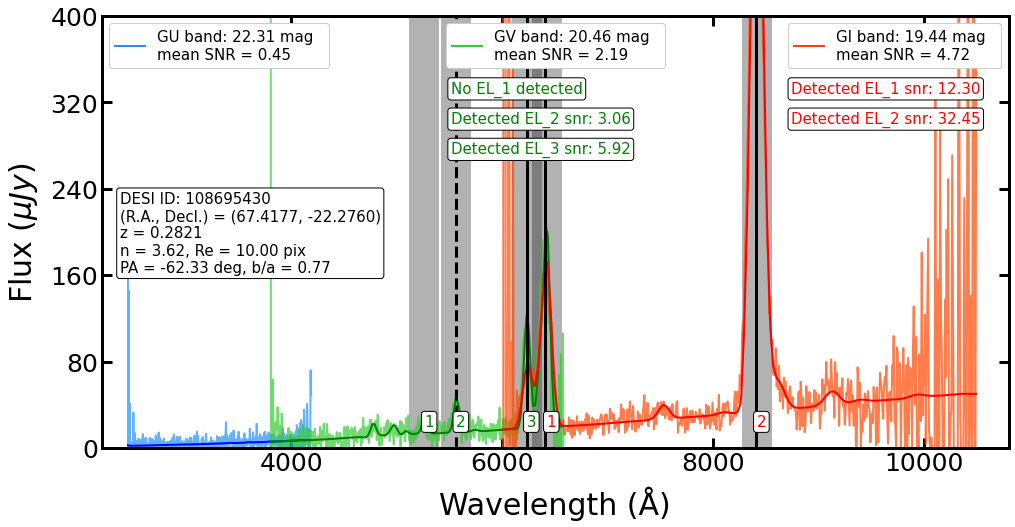

In [296]:
eldemo(26677,400,None)

catindex =  4902
index =  4901
gvidx1 =  None
gvidx2 =  None
giidx1 =  None
giidx2 =  None


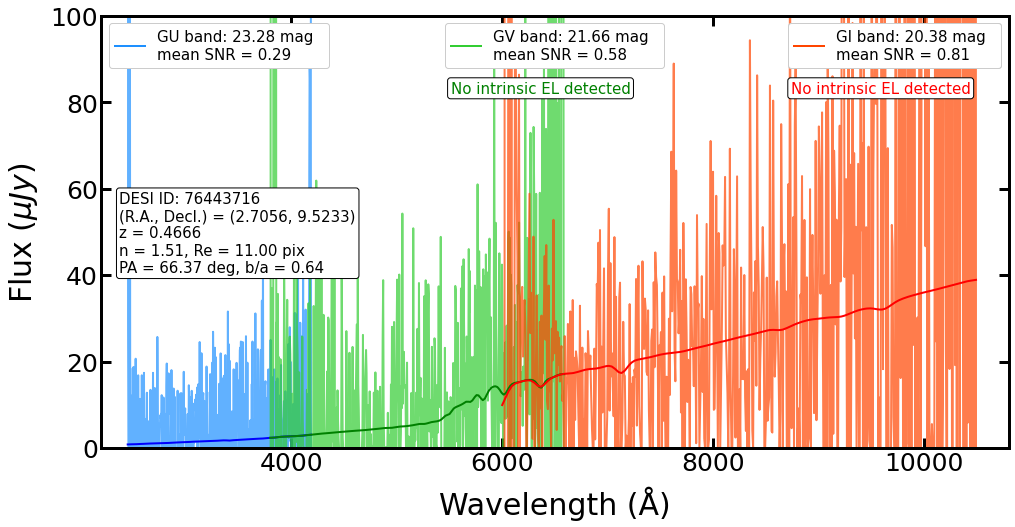

In [297]:
eldemo(4901,100,None)

catindex =  60241
index =  60240
gvidx1 =  None
gvidx2 =  None
giidx1 =  18372
giidx2 =  16822


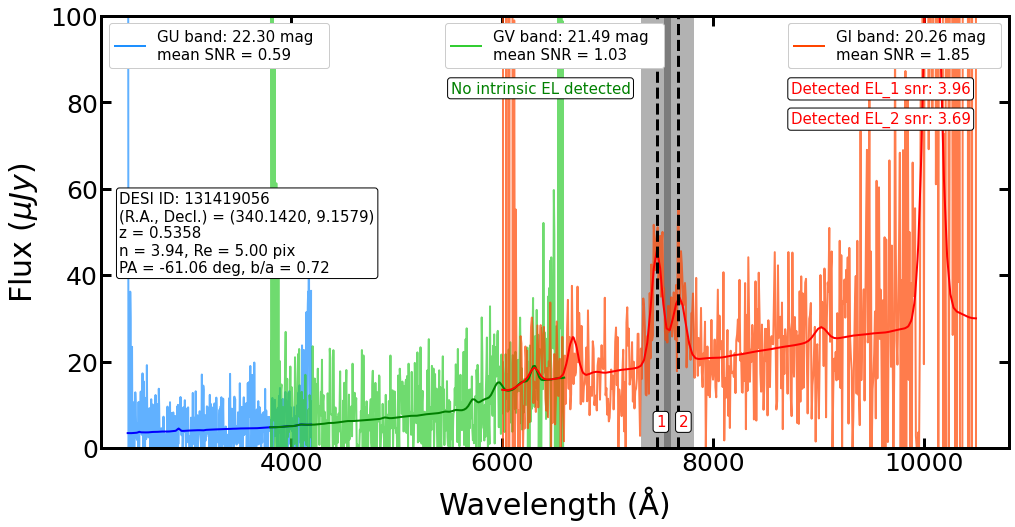

In [299]:
eldemo(60240,100,None)

catindex =  2838
index =  2837
gvidx1 =  None
gvidx2 =  None
giidx1 =  None
giidx2 =  None


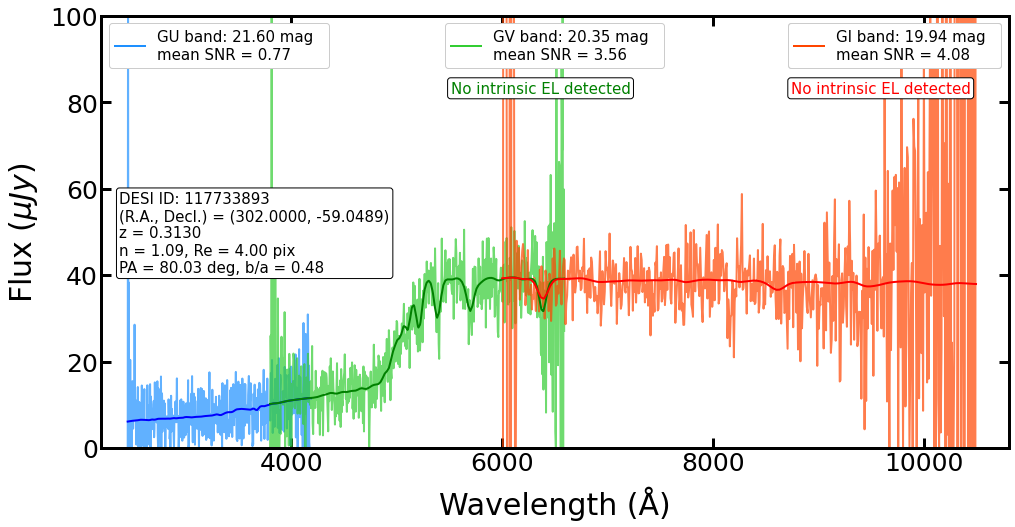

In [300]:
eldemo(2837,100,None)

catindex =  13718
index =  13717
gvidx1 =  5366
gvidx2 =  4824
giidx1 =  4184
giidx2 =  3833


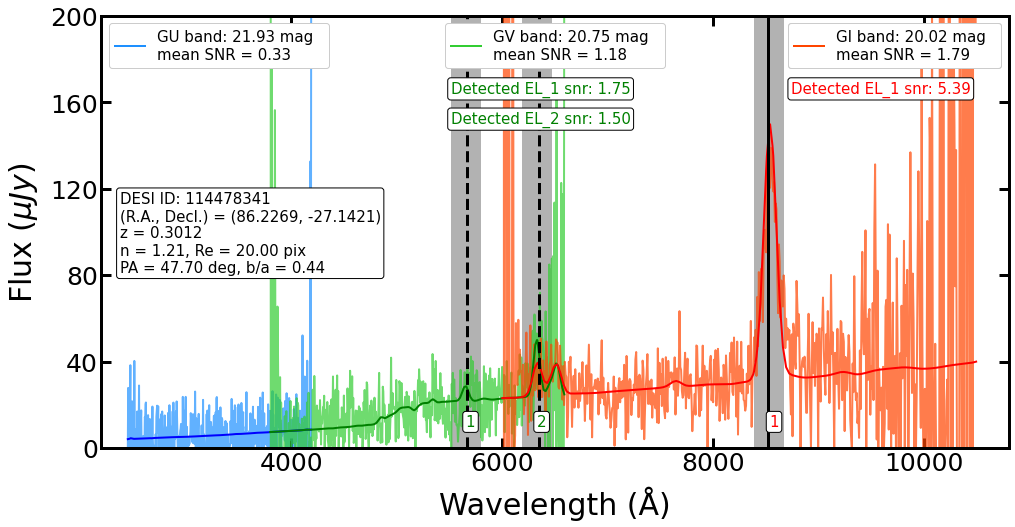

In [301]:
eldemo(13717,200,None)

catindex =  72475
index =  72474
gvidx1 =  28407
gvidx2 =  25655
giidx1 =  22004
giidx2 =  20175


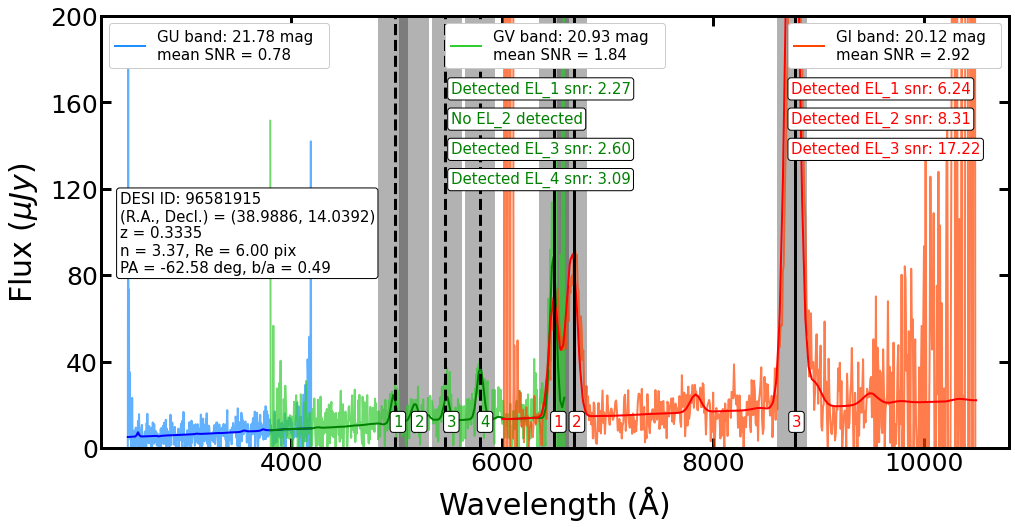

In [302]:
eldemo(72474,200,None)

catindex =  42820
index =  42819
gvidx1 =  None
gvidx2 =  None
giidx1 =  None
giidx2 =  None


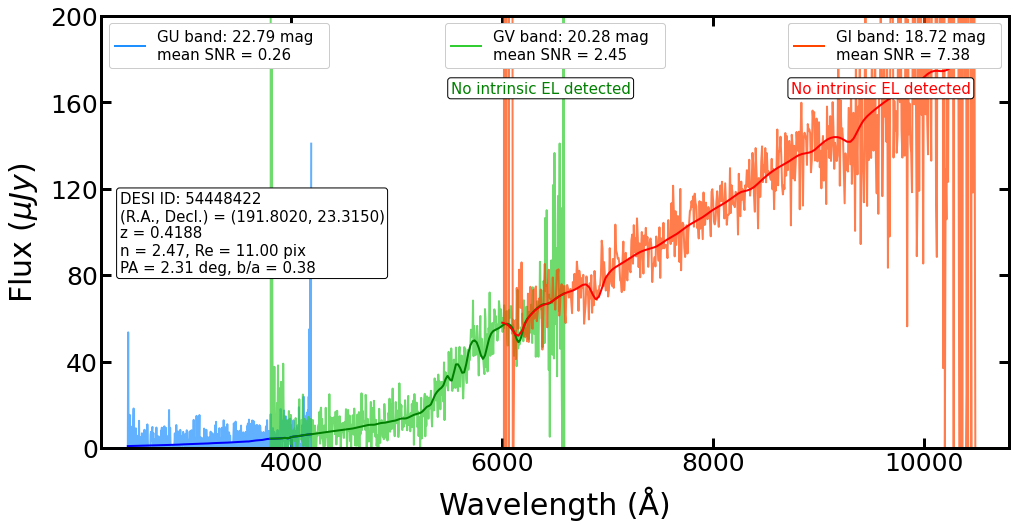

In [303]:
eldemo(42819,200,None)

catindex =  36138
index =  36137
gvidx1 =  None
gvidx2 =  None
giidx1 =  None
giidx2 =  None


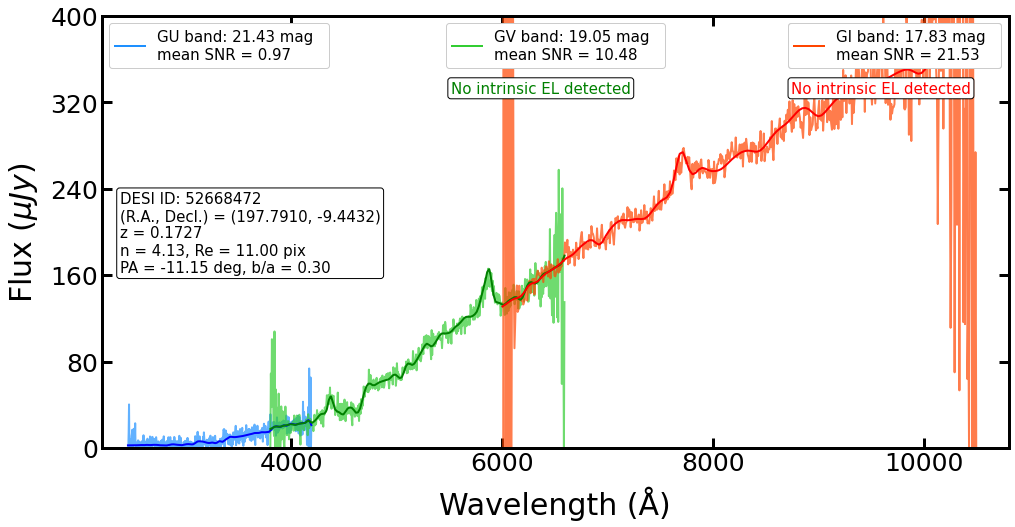

In [304]:
eldemo(36137,400,None)

catindex =  11194
index =  11193
gvidx1 =  4413
gvidx2 =  3956
giidx1 =  3419
giidx2 =  3148


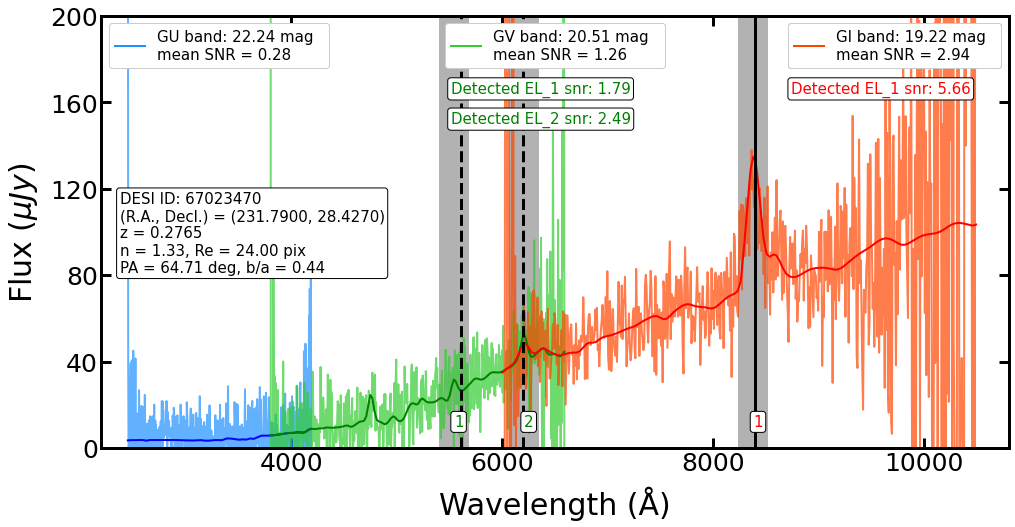

In [305]:
eldemo(11193,200,None)

catindex =  18822
index =  18821
gvidx1 =  7339
gvidx2 =  6592
giidx1 =  5754
giidx2 =  5283


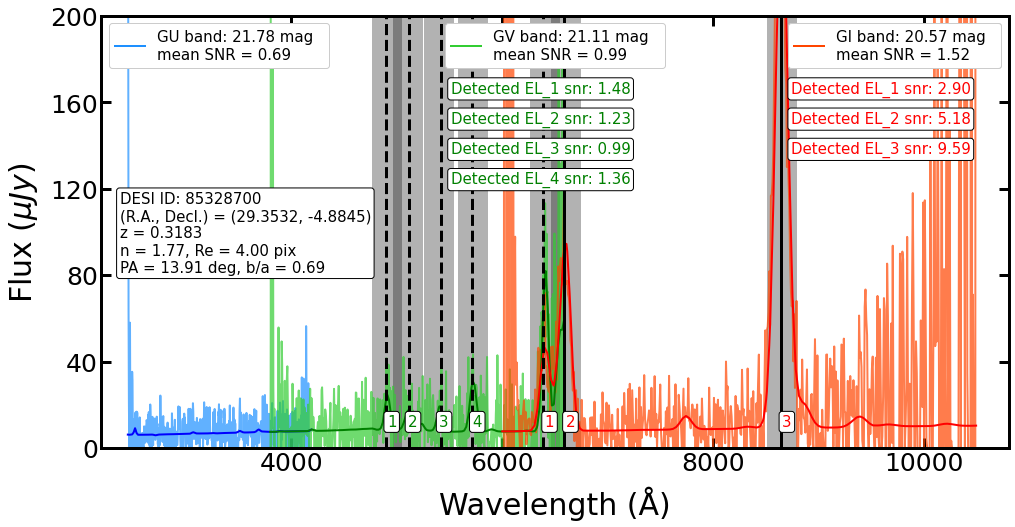

In [306]:
eldemo(18821,200,None)

catindex =  49682
index =  49681
gvidx1 =  19502
gvidx2 =  17590
giidx1 =  15166
giidx2 =  13900


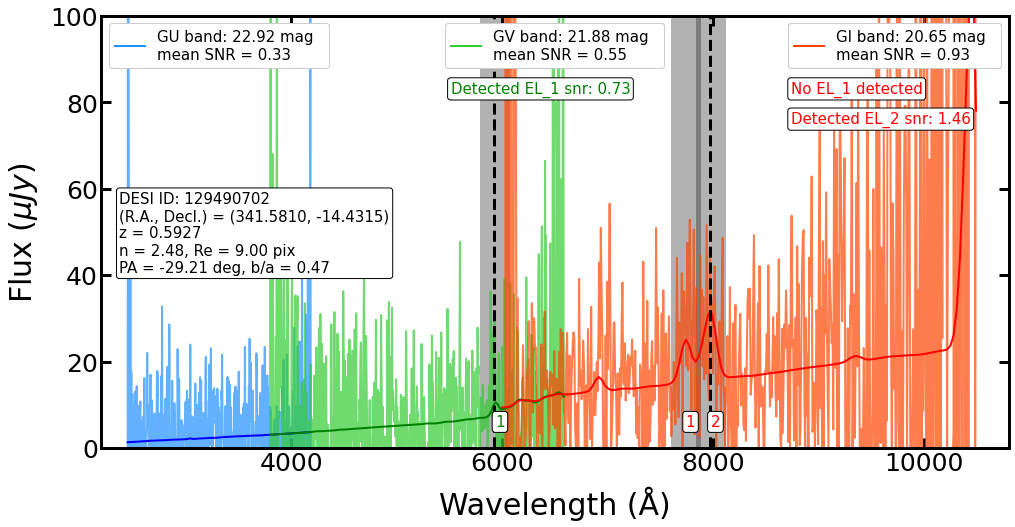

In [307]:
eldemo(49681,100,None)

catindex =  13294
index =  13293
gvidx1 =  5233
gvidx2 =  4707
giidx1 =  4057
giidx2 =  3716


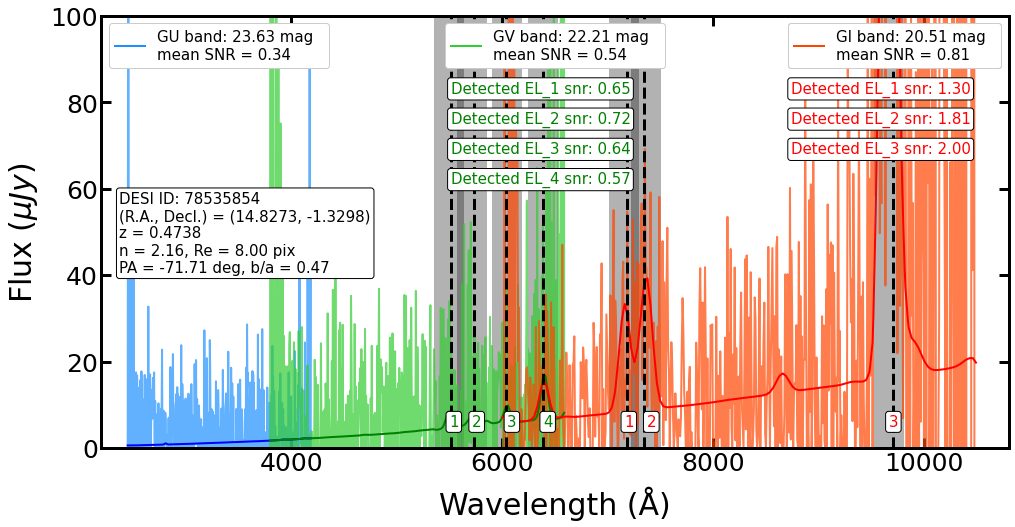

In [308]:
eldemo(13293,100,None)

catindex =  58397
index =  58396
gvidx1 =  22961
gvidx2 =  20733
giidx1 =  17815
giidx2 =  16319


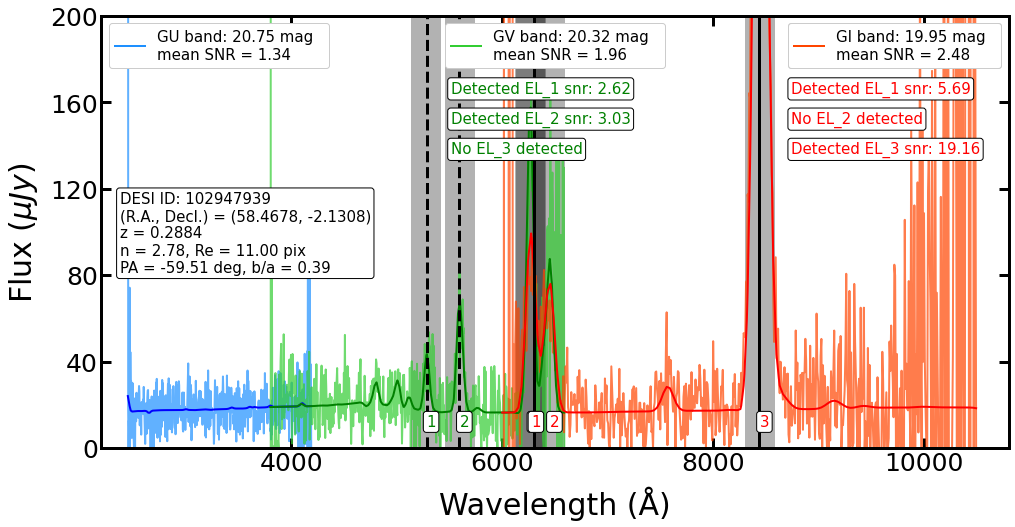

In [310]:
eldemo(58396,200,None)

catindex =  5324
index =  5323
gvidx1 =  2123
gvidx2 =  1892
giidx1 =  1610
giidx2 =  1493


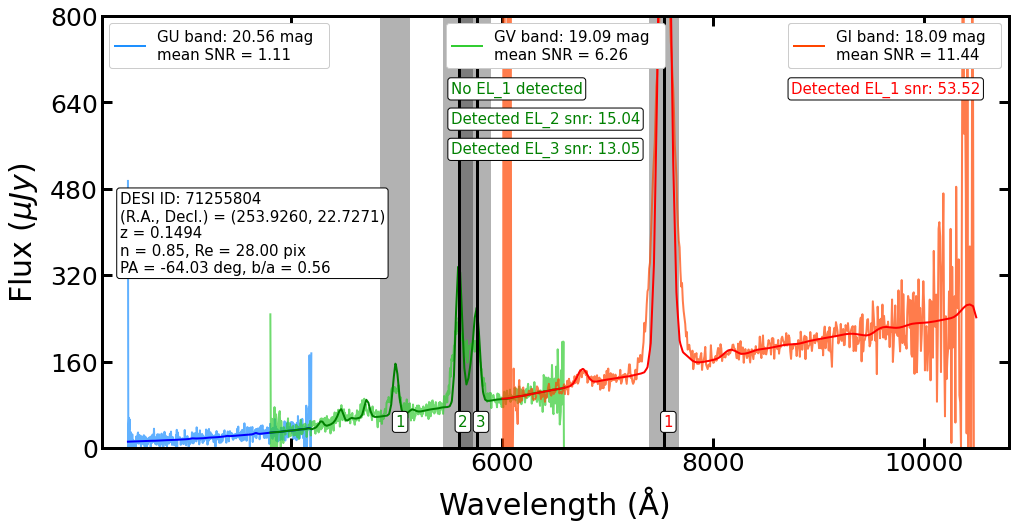

In [311]:
eldemo(5323,800,None)

catindex =  66199
index =  66198
gvidx1 =  None
gvidx2 =  None
giidx1 =  None
giidx2 =  None


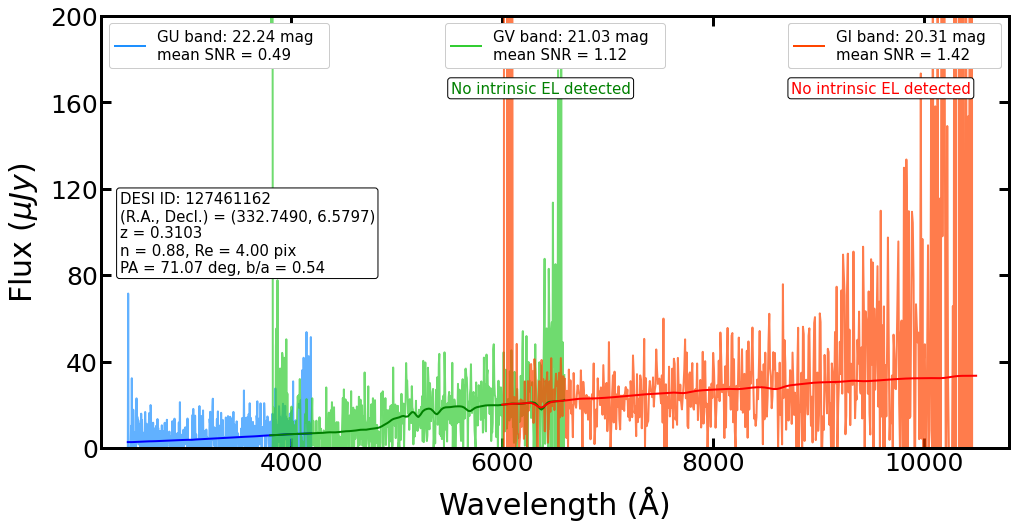

In [312]:
eldemo(np.random.randint(len(cat['ID'][:])),200,None)

In [ ]:
eldemo(np.random.randint(len(cat['ID'][:])),200,None)

In [ ]:
eldemo(np.random.randint(len(cat['ID'][:])),200,None)

In [ ]:
eldemo(np.random.randint(len(cat['ID'][:])),200,None)